# Introduction to Amazon Sagemaker

In [73]:
# !pip install --upgrade pip
# !pip install --disable-pip-version-check -q sagemaker
# !pip install --disable-pip-version-check -q awswrangler
# !pip install --disable-pip-version-check -q pandas
# !pip install --disable-pip-version-check -q numpy
# !pip install --disable-pip-version-check -q matplotlib
# !pip install --disable-pip-version-check -q seaborn

## Uploading data into Sagemake enviroment
The details on [uploading data to Amazon sagemaker can be found here](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-ui.html)

<img src="Upload data.png">


In [14]:
import pandas as pd

df = pd.read_csv('Review_sample.csv')

In [15]:
df.head()

,Review Text,Rating,Product_category,Product_name
0,If this product was in petite i would get the...,4,Tops,Blouses
1,Love this dress! it's sooo pretty. i happene...,5,Dresses,Dresses
2,I had such high hopes for this dress and reall...,3,Dresses,Dresses
3,I love love love this jumpsuit. it's fun fl...,5,Bottoms,Pants
4,This shirt is very flattering to all due to th...,5,Tops,Blouses


## Creating the Amazon s3 bucket 
Additional details on [specifing S3 bucket can be found here](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-ex-bucket.html)

In [16]:
import boto3
import sagemaker

In [19]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
account_id = sess.account_id
region = boto3.Session().region_name
print(f'S3 Bucket: {bucket}')
print(f'Role: {role}')
print(f'Account ID: {account_id}')
print(f'Region: {region}')

S3 Bucket: sagemaker-us-east-1-398377607838
Role: arn:aws:iam::398377607838:role/sagemaker-studio-vpc-firewall-us-east-1-sagemaker-execution-role
Account ID: <bound method Session.account_id of <sagemaker.session.Session object at 0x7f614ff08d90>>
Region: us-east-1


### confirm bucket creation

In [20]:
!aws s3 ls s3://$bucket/

## Coping the data into S3 bucket

In [21]:
!aws s3 cp ./Review_sample.csv s3://$bucket/data/Transformed/Review_sample.csv 

upload: ./Review_sample.csv to s3://sagemaker-us-east-1-398377607838/data/Transformed/Review_sample.csv


## Create Amazon Glue Catalog Database
Amazon Glue Catalog is used for indexing the location, schema and runtime metrics of your data.

The catalog contains meta data and not the real data

Additional information on [populating the AWS Glue Data Catalog](https://docs.aws.amazon.com/glue/latest/dg/populate-data-catalog.html) can be found here.

### Create database

In [22]:
import awswrangler as wr

In [23]:
wr.catalog.create_database(
                           name = 'db_reviews',
                           exist_ok = True
                          )

In [24]:
# check that databse is created
dbs = wr.catalog.get_databases()
for db in dbs:
    print(db['Name'])

db_reviews


In [27]:
df.head()

,Review Text,Rating,Product_category,Product_name
0,If this product was in petite i would get the...,4,Tops,Blouses
1,Love this dress! it's sooo pretty. i happene...,5,Dresses,Dresses
2,I had such high hopes for this dress and reall...,3,Dresses,Dresses
3,I love love love this jumpsuit. it's fun fl...,5,Bottoms,Pants
4,This shirt is very flattering to all due to th...,5,Tops,Blouses


#### Register data with AWS Glue Catalog

In [28]:
wr.catalog.create_csv_table(
                            database = 'db_reviews',
                            table = 'Reviews',
                            path = f's3://{bucket}/data/Transformed/',
                            columns_types = {
                                             'Review Text' : 'string',
                                             'Rating' : 'string',
                                             'Product_category' : 'string',
                                             'Product_name' : 'string',
                                            },
                            mode = 'overwrite',
                            skip_header_line_count = 1,
                            sep = ','
                           )

In [29]:
# check the table shape
table = wr.catalog.table(database = 'db_reviews', 
                         table = 'Reviews'
                        )
table

,Column Name,Type,Partition,Comment
0,review text,string,False,
1,rating,string,False,
2,product_category,string,False,
3,product_name,string,False,


## Quering data using Amazon Athena

### Creating default S3 bucket for Amazon Athena

In [30]:
wr.athena.create_athena_bucket()

's3://aws-athena-query-results-398377607838-us-east-1/'

### Running SQl queries using Amazon Athena

#### What is the number of reviews per rating?

In [35]:
# SQL statement
review_count = """
    SELECT rating
        ,COUNT(*) As Review_count
    FROM Reviews
    GROUP BY rating
    ORDER BY rating 
"""

print(review_count)


    SELECT rating
        ,COUNT(*) As Review_count
    FROM Reviews
    GROUP BY rating
    ORDER BY rating 



In [38]:
df_review_count = wr.athena.read_sql_query(
                                              sql = review_count,
                                              database = 'db_reviews'
                                              
                                             )

In [39]:
print(df_review_count)

  rating  review_count
0      1           842
1      2          1565
2      3          2871
3      4          5077
4      5         13131


### Visualizing data

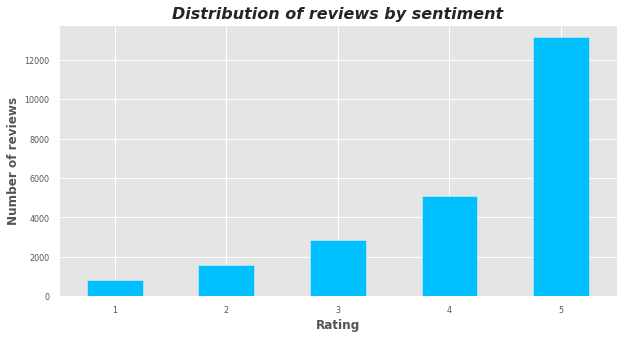

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize' : (10.0, 5.0),
           })
plt.style.use('ggplot')

df_review_count.plot(kind = 'bar', x='rating', y='review_count', color='deepskyblue', rot=0, legend=None)
plt.title('Distribution of reviews by sentiment', fontsize=16, fontname='georgia', fontweight='bold', fontstyle='italic')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Rating', fontsize=12, fontweight='bold')
plt.ylabel('Number of reviews', fontsize=12, fontweight='bold')
plt.show()

### Which product category has the highest number of reviews?

In [52]:
category_count = """
SELECT 
    product_category Category
    ,COUNT(*) Review_count
FROM Reviews
GROUP BY product_category
ORDER BY Review_count DESC
"""

In [55]:
df_category_count = wr.athena.read_sql_query(
                                             sql=category_count
                                             ,database = 'db_reviews'
                                            )

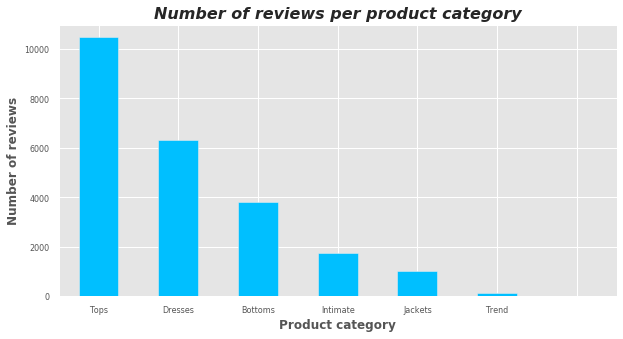

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize' : (10.0, 5.0),
           })
plt.style.use('ggplot')

df_category_count.plot(kind = 'bar', x='category', y='review_count', 
                       color='deepskyblue', rot=0, legend=None)
plt.title('Number of reviews per product category', fontsize=16, 
          fontname='georgia', fontweight='bold', fontstyle='italic')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Product category', fontsize=12, fontweight='bold')
plt.ylabel('Number of reviews', fontsize=12, fontweight='bold')
plt.show()

#### Which product has the lowest number of reviews

In [58]:
product_count = """
SELECT 
    product_name
    ,COUNT(*) Review_count
FROM Reviews
GROUP BY product_name
ORDER BY Review_count DESC
"""

In [60]:
df_product_count = wr.athena.read_sql_query(
                                            sql=product_count,
                                            database = 'db_Reviews'
                                           )

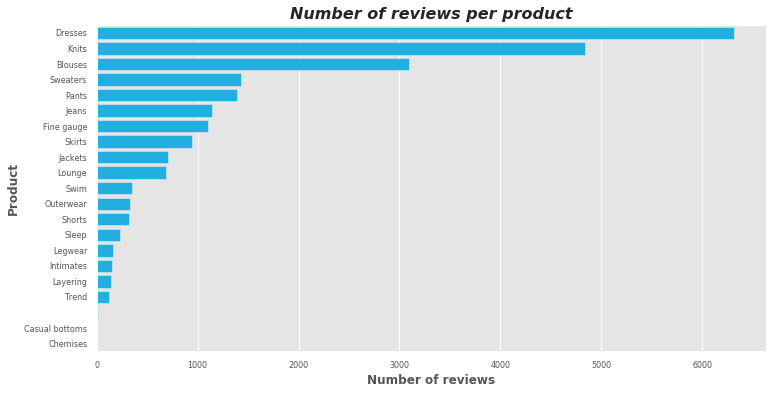

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize' : (12.0, 6.0),
           })
plt.style.use('ggplot')

sns.barplot(x='review_count', y='product_name', data=df_product_count, color='deepskyblue',)

# df_product_count.plot(kind = 'bar', x='product_name', y='review_count', 
#                        color='deepskyblue', rot=0, legend=None)
plt.title('Number of reviews per product', fontsize=16, 
          fontname='georgia', fontweight='bold', fontstyle='italic')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.ylabel('Product', fontsize=12, fontweight='bold')
plt.xlabel('Number of reviews', fontsize=12, fontweight='bold')
plt.show()

#### What is the sentiment of most customers

In [84]:
sentiment_count = """
WITH Sentiments AS (
SELECT 
    CASE 
        WHEN rating IN ('1','2') THEN -1
        WHEN rating IN ('4', '5') THEN 1
        ELSE 0 
        END Sentiment
FROM Reviews
)
SELECT 
    Sentiment
    ,COUNT(*) Review_count
FROM   Sentiments 
GROUP BY Sentiment
ORDER BY Sentiment
        
"""

In [85]:
df_sentiment_count = wr.athena.read_sql_query(
                                              sql=sentiment_count,
                                              database='db_reviews'
                                             )

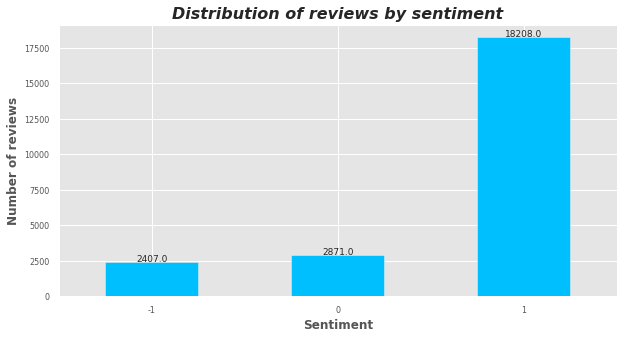

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize' : (10.0, 5.0),
           })
plt.style.use('ggplot')

axes = df_sentiment_count.plot(kind = 'bar', x='sentiment', y='review_count', color='deepskyblue', rot=0, legend=None)
plt.title('Distribution of reviews by sentiment', fontsize=16, fontname='georgia', fontweight='bold', fontstyle='italic')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Sentiment', fontsize=12, fontweight='bold')
plt.ylabel('Number of reviews', fontsize=12, fontweight='bold')
for ax in axes.patches:
    value = '{}'.format(round(ax.get_height(),0))
    axes.text(ax.get_x()+(ax.get_width()*0.5)
             ,250+ax.get_height()
             ,value
             ,ha='center' 
             ,va='center'
             ,fontsize=9
             #,rotation=90
            )
plt.show()